In [35]:
from pre_processing import train_test_split
import pandas as pd

import numpy as np
from itertools import product
import matplotlib.pyplot as plt
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, roc_curve, auc, roc_auc_score, average_precision_score, precision_recall_curve

In [17]:
df =pd.read_csv("data/labelled_w_features.csv")
df.head(5)

,transcript_id,transcript_position,kmer_sequence,dwelling_length1,sd_signal1,mean_signal1,dwelling_length2,sd_signal2,mean_signal2,dwelling_length3,...,CG_count,CT_count,GA_count,GC_count,GG_count,GT_count,TA_count,TC_count,TG_count,TT_count
0,ENST00000000233,244,AAGACCA,0.00299,2.06,125.0,0.01770,10.40,122.0,0.00930,...,0,0,1,0,0,0,0,0,0,0
1,ENST00000000233,244,AAGACCA,0.00631,2.53,125.0,0.00844,4.67,126.0,0.01030,...,0,0,1,0,0,0,0,0,0,0
2,ENST00000000233,244,AAGACCA,0.00465,3.92,109.0,0.01360,12.00,124.0,0.00498,...,0,0,1,0,0,0,0,0,0,0
3,ENST00000000233,244,AAGACCA,0.00398,2.06,125.0,0.00830,5.01,130.0,0.00498,...,0,0,1,0,0,0,0,0,0,0
4,ENST00000000233,244,AAGACCA,0.00664,2.92,120.0,0.00266,3.94,129.0,0.01300,...,0,0,1,0,0,0,0,0,0,0


In [18]:
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

# k-mer sequences are all of the same length
sequence_length = len(df['kmer_sequence'].iloc[0])

# Tokenize the characters
tokenizer = Tokenizer(char_level=True)
tokenizer.fit_on_texts(df['kmer_sequence'])

# Convert k-mer sequences to sequences of integers
df["kmer_sequence_int"] = tokenizer.texts_to_sequences(df['kmer_sequence'])

# Calculate the mean and create new columns
df['X1'] = df['kmer_sequence_int'].apply(lambda x: np.mean(x[:5]))
df['X2'] = df['kmer_sequence_int'].apply(lambda x: np.mean(x[1:6]))
df['X3'] = df['kmer_sequence_int'].apply(lambda x: np.mean(x[2:7]))


In [28]:
NUM_NEIGHBORING_FEATURES = 1
CENTER_MOTIFS = [['A', 'G', 'T'], ['G', 'A'], ['A'], ['C'], ['A', 'C', 'T']]
FLANKING_MOTIFS = [['G', 'A', 'C', 'T'] for i in range(NUM_NEIGHBORING_FEATURES)]
ALL_KMERS = list(["".join(x) for x in product(*(FLANKING_MOTIFS + CENTER_MOTIFS + FLANKING_MOTIFS))])
ALL_KMERS = np.unique(np.array(list(map(lambda x: [x[i:i+5] for i in range(len(x) -4)],
                                    ALL_KMERS))).flatten())
KMER_TO_INT = {ALL_KMERS[i]: i for i in range(len(ALL_KMERS))}
INT_TO_KMER =  {i: ALL_KMERS[i] for i in range(len(ALL_KMERS))}
M6A_KMERS = ["".join(x) for x in product(*CENTER_MOTIFS)]

# Calculate the mean and create new columns
df['Z1'] = df['kmer_sequence'].apply(lambda x: KMER_TO_INT[x[:5]])
df['Z2'] = df['kmer_sequence'].apply(lambda x: KMER_TO_INT[x[1:6]])
df['Z3'] = df['kmer_sequence'].apply(lambda x: KMER_TO_INT[x[2:7]])

In [29]:
df.dtypes

transcript_id           object
transcript_position      int64
kmer_sequence           object
dwelling_length1       float64
sd_signal1             float64
mean_signal1           float64
dwelling_length2       float64
sd_signal2             float64
mean_signal2           float64
dwelling_length3       float64
sd_signal3             float64
mean_signal3           float64
gene_id                 object
label                    int64
A_count                  int64
C_count                  int64
G_count                  int64
T_count                  int64
AA_count                 int64
AC_count                 int64
AG_count                 int64
AT_count                 int64
CA_count                 int64
CC_count                 int64
CG_count                 int64
CT_count                 int64
GA_count                 int64
GC_count                 int64
GG_count                 int64
GT_count                 int64
TA_count                 int64
TC_count                 int64
TG_count

In [30]:
from sklearn.model_selection import GroupShuffleSplit 

def train_test_split(labelled_data, random_state, test_size=0.2):
    """Splits the labelled data into training testing

    Args:
        labelled_data (pd.DataFrame): labelled data from `add_labels()` or the data could have added features from `add_features()`
        random_state (int): random integer value for the splitting state
        test_size (float, optional): Size of the test set. Defaults to 0.2.

    Returns:
        (`train_x`, `train_y`, `test_x`, `test_y`): Training data features, Training data labels, Testing data features, Testing data labels   
        
    """
    
    splitter = GroupShuffleSplit(test_size=test_size, n_splits=2, random_state = random_state)
    # split across the gene_id
    split = splitter.split(labelled_data, groups=labelled_data['gene_id'])
    train_inds, test_inds = next(split)

    train = labelled_data.iloc[train_inds]
    train_x = train[train.columns.difference(["label"])]
    train_y = train[["label"]]
    test = labelled_data.iloc[test_inds]
    test_x = test[test.columns.difference(["label"])]
    test_y = test[["label"]]

    return (train_x, train_y, test_x, test_y)

In [31]:
train_x, train_y, test_x, test_y = train_test_split(df, random_state=42)

In [32]:
feature_cols = ['AA_count', 'AC_count', 'AG_count', 'AT_count', 'A_count', 'CA_count',
       'CC_count', 'CG_count', 'CT_count', 'C_count', 'GA_count', 'GC_count',
       'GG_count', 'GT_count', 'G_count', 'TA_count', 'TC_count', 'TG_count',
       'TT_count', 'T_count', 'dwelling_length1', 'dwelling_length2',
       'dwelling_length3', 'mean_signal1',
       'mean_signal2', 'mean_signal3', 'sd_signal1', 'sd_signal2',
       'sd_signal3','X1', 'X2','X3']

In [8]:
train_x[feature_cols]

,AA_count,AC_count,AG_count,AT_count,A_count,CA_count,CC_count,CG_count,CT_count,C_count,...,dwelling_length3,mean_signal1,mean_signal2,mean_signal3,sd_signal1,sd_signal2,sd_signal3,X1,X2,X3
0,1,1,1,0,4,1,1,0,0,2,...,0.00930,125.0,122.0,84.1,2.06,10.40,10.90,1.6,1.8,1.8
1,1,1,1,0,4,1,1,0,0,2,...,0.01030,125.0,126.0,80.9,2.53,4.67,6.30,1.6,1.8,1.8
2,1,1,1,0,4,1,1,0,0,2,...,0.00498,109.0,124.0,79.6,3.92,12.00,2.13,1.6,1.8,1.8
3,1,1,1,0,4,1,1,0,0,2,...,0.00498,125.0,130.0,80.4,2.06,5.01,3.78,1.6,1.8,1.8
4,1,1,1,0,4,1,1,0,0,2,...,0.01300,120.0,129.0,82.2,2.92,3.94,7.15,1.6,1.8,1.8
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
11027101,0,1,0,1,2,1,0,0,0,1,...,0.01000,108.0,116.0,76.4,7.49,10.20,2.01,2.8,2.2,2.2
11027102,0,1,0,1,2,1,0,0,0,1,...,0.01760,109.0,110.0,74.6,1.91,12.30,2.61,2.8,2.2,2.2
11027103,0,1,0,1,2,1,0,0,0,1,...,0.00316,105.0,113.0,85.3,4.58,6.58,2.28,2.8,2.2,2.2
11027104,0,1,0,1,2,1,0,0,0,1,...,0.00664,109.0,108.0,76.8,2.33,10.40,4.44,2.8,2.2,2.2


In [36]:
def logistic_model(X_train, y_train, X_test, y_test):
    # Fit the logistic regression model
    model = LogisticRegression(solver="saga")
    model.fit(X_train, y_train.values.ravel())

    # Predict probabilities
    y_pred = model.predict(X_test)
    y_pred_prob = model.predict_proba(X_test)[:, 1]

    # Print classification report
    print("Classification Report:")
    print(classification_report(y_test, y_pred))

    # Compute ROC curve
    fpr, tpr, thresholds = roc_curve(y_test, y_pred_prob)
    roc_auc = auc(fpr, tpr)

    # Compute Precision-Recall Curve
    precision, recall, _ = precision_recall_curve(y_test, y_pred_prob)

    # Calculate the area under the Precision-Recall Curve (PRC)
    prc_auc = average_precision_score(y_test, y_pred_prob)

    # Print ROC AUC score
    print('ROC AUC Score:', roc_auc_score(y_test, y_pred_prob))

    # Print PRC score
    print('PRC AUC Score:', prc_auc)

    # Plot ROC and PRC curves
    plt.figure(figsize=(10, 5))
    plt.subplot(1, 2, 1)
    plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic')
    plt.legend(loc='lower right')

    plt.subplot(1, 2, 2)
    plt.plot(recall, precision, color='blue', lw=2, label='PRC')
    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.title('Precision-Recall Curve')
    plt.legend(loc='lower left')

    plt.tight_layout()
    plt.show()


c:\Users\jonas\anaconda3\Lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


Classification Report:
              precision    recall  f1-score   support

           0       0.95      1.00      0.97   2200171
           1       0.64      0.03      0.06    115629

    accuracy                           0.95   2315800
   macro avg       0.79      0.52      0.52   2315800
weighted avg       0.94      0.95      0.93   2315800

ROC AUC Score: 0.8041452988894463
PRC AUC Score: 0.24438442751138417


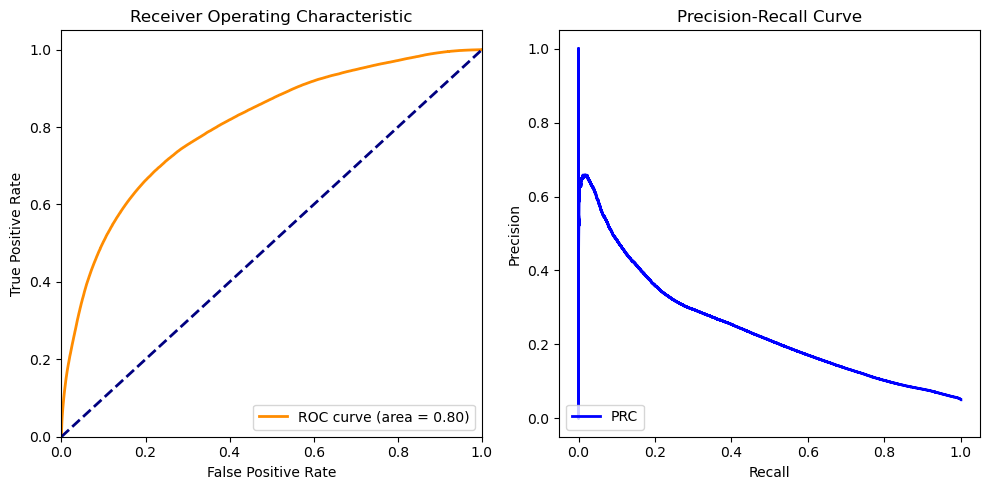

In [37]:
logistic_model(train_x[feature_cols], train_y, test_x[feature_cols], test_y)

In [38]:
feature_cols_wo_emb = ['AA_count', 'AC_count', 'AG_count', 'AT_count', 'A_count', 'CA_count',
       'CC_count', 'CG_count', 'CT_count', 'C_count', 'GA_count', 'GC_count',
       'GG_count', 'GT_count', 'G_count', 'TA_count', 'TC_count', 'TG_count',
       'TT_count', 'T_count', 'dwelling_length1', 'dwelling_length2',
       'dwelling_length3', 'mean_signal1',
       'mean_signal2', 'mean_signal3', 'sd_signal1', 'sd_signal2',
       'sd_signal3']

c:\Users\jonas\anaconda3\Lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


Classification Report:
              precision    recall  f1-score   support

           0       0.95      1.00      0.97   2200171
           1       0.61      0.00      0.00    115629

    accuracy                           0.95   2315800
   macro avg       0.78      0.50      0.49   2315800
weighted avg       0.93      0.95      0.93   2315800

ROC AUC Score: 0.7946815736996531
PRC AUC Score: 0.2217529461752734


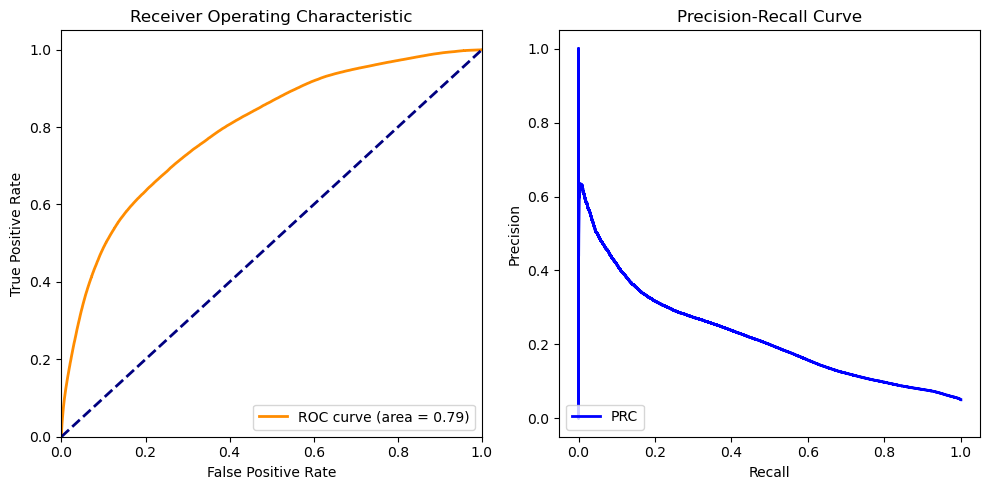

In [39]:
logistic_model(train_x[feature_cols_wo_emb], train_y, test_x[feature_cols_wo_emb], test_y)

In [40]:
feature_cols_w_66emb = ['AA_count', 'AC_count', 'AG_count', 'AT_count', 'A_count', 'CA_count',
       'CC_count', 'CG_count', 'CT_count', 'C_count', 'GA_count', 'GC_count',
       'GG_count', 'GT_count', 'G_count', 'TA_count', 'TC_count', 'TG_count',
       'TT_count', 'T_count', 'dwelling_length1', 'dwelling_length2',
       'dwelling_length3', 'mean_signal1',
       'mean_signal2', 'mean_signal3', 'sd_signal1', 'sd_signal2',
       'sd_signal3','Z1', 'Z2','Z3']

c:\Users\jonas\anaconda3\Lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


Classification Report:
              precision    recall  f1-score   support

           0       0.95      1.00      0.97   2200171
           1       0.64      0.03      0.06    115629

    accuracy                           0.95   2315800
   macro avg       0.80      0.52      0.52   2315800
weighted avg       0.94      0.95      0.93   2315800

ROC AUC Score: 0.8039047210139691
PRC AUC Score: 0.24844606839850103


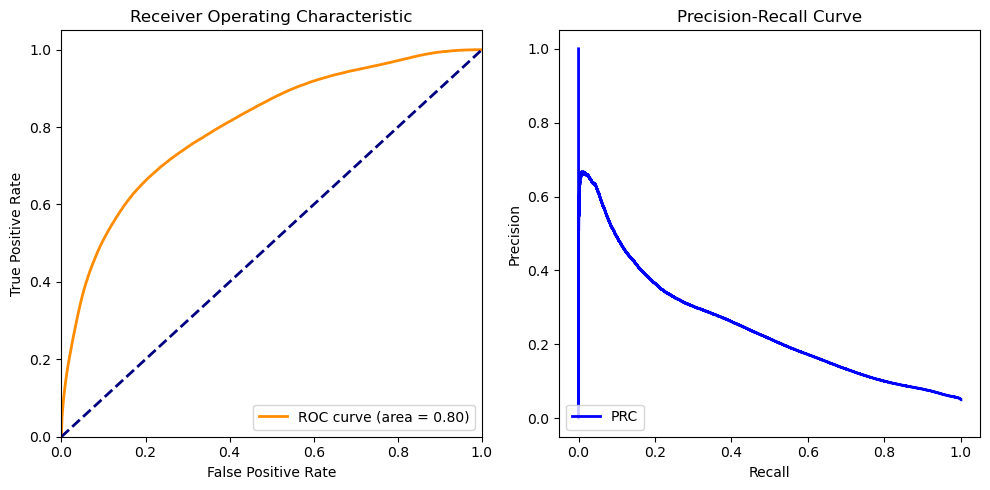

In [41]:
logistic_model(train_x[feature_cols_w_66emb], train_y, test_x[feature_cols_w_66emb], test_y)